<table class="table table-bordered">
    <tr>
        <th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment - Food Classification Model (Individual)</h2><h3>AY2025/26 Semester</h3></th>
    </tr>
</table>

<h3>Student Name: Lim Ai Sim Elizabeth (3440680F)</h3>

## **Introduction**

This notebook is for model development using pretrained model "InceptionV3" on top of the dense layers previously build for the 'built-from-stratch' model.

Note that the observations and changes are not always recorded in this notebook, rather an excel sheet was used to compare graphs and note down observations.

(Gemini in Google Colab was also use to help generate and debug some of the codes used in this notebook.)

### Import Libraries and environmental setup

In [ ]:
# FOR AWS setup only

!ln -sf /opt/conda/nvvm/libdevice/libdevice.10.bc ./libdevice.10.bc

In [ ]:
# Import the Required Packages

from tensorflow import keras
print('keras: ', keras.__version__)
# Keras version must be at least 2.6.0

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-06-02 11:12:05.947990: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 11:12:05.960983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748862725.978241    1265 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748862725.983708    1265 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-02 11:12:06.000533: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

keras:  3.9.2


## **1) Data import, transformation and exploration**

In [ ]:
# FOR COLAB DATA LOADING

import os
import zipfile
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Define the path to your zip file and the target directory for extraction
zip_file_path = '/content/drive/My Drive/Colab Notebooks/DLIR/Food.zip'
extract_dir = '/content/drive/My Drive/Colab Notebooks/DLIR/'


#Extract the zip file (commented out once extracted)
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# Define paths to the train, validation, and test directories
train_dir = os.path.join(extract_dir, 'Food', 'train')
validation_dir = os.path.join(extract_dir, 'Food','validation')
test_dir = os.path.join(extract_dir, 'Food','test')

# check path
print(train_dir)
print(validation_dir)
print(test_dir)

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/DLIR/Food/train
/content/drive/My Drive/Colab Notebooks/DLIR/Food/validation
/content/drive/My Drive/Colab Notebooks/DLIR/Food/test


In [ ]:
# FOR AWS DATALOADING

import os
import zipfile


# # Define the path to your zip file and the target directory for extraction
# zip_file_path = 'Food.zip'
# extract_dir = os.getcwd()

# # Extract the zip file (commented out once extracted)
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# Define paths to the train, validation, and test directories
train_dir = 'Food/train'
validation_dir = 'Food/validation'
test_dir = 'Food/test'

# check path
print(train_dir)
print(validation_dir)
print(test_dir)

Food/train
Food/validation
Food/test


### Data preparation and augmentation

In [ ]:
# Generation  of augmented data
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

img_size = 150

train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.3,
      horizontal_flip=True,
      brightness_range=[0.8,1.2],
      fill_mode='nearest')

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=25,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=25,
        class_mode='categorical')


# Define test_datagen
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=25,
        class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [ ]:
# checking the shape of the data

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (25, 150, 150, 3)
labels batch shape: (25, 10)


## **2) Develop the Image Classification Model using InceptionV3**

The InceptionV3 model was imported from the Keras Applications library, excluding its top classification layer. This allowed the utilization of only its pre-trained convolutional base for feature extraction, which was then coupled with custom-built dense layers.



### Model 1: Food IN-1

Importing Model: Inception V3 from keras application library.

In [ ]:
# get the model InceptionV3

from keras.applications.inception_v3 import InceptionV3
img_size = 150

conv_base = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_size, img_size, 3),
    pooling=None,
)

conv_base.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
# Build the model

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import tensorflow as tf

# Instead of adding layers individually, create a new model
# using the InceptionV3 base as a layer
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Freeze the convolutional base to prevent weight updates during initial training
conv_base.trainable = False

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,208,106 (157.20 MB)

 Trainable params: 19,405,322 (74.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history = model.fit(
      train_generator,
      epochs=50,
      validation_data=validation_generator,
      verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 7360s 24s/step - acc: 0.4348 - loss: 4.5861 - val_acc: 0.6870 - val_loss: 2.7120
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 77s 258ms/step - acc: 0.6283 - loss: 2.8480 - val_acc: 0.6795 - val_loss: 2.4483
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 77s 256ms/step - acc: 0.6650 - loss: 2.4096 - val_acc: 0.7140 - val_loss: 2.1362
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 254ms/step - acc: 0.6893 - loss: 2.0859 - val_acc: 0.7460 - val_loss: 1.7814
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 254ms/step - acc: 0.7029 - loss: 1.9087 - val_acc: 0.7540 - val_loss: 1.6220
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 253ms/step - acc: 0.7057 - loss: 1.7251 - val_acc: 0.7510 - val_loss: 1.5212
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 77s 256ms/step - acc: 0.6972 - loss: 1.6244 - val_acc: 0.7690 - val_loss: 1.3620
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 253ms/step - acc: 0.7134 - loss: 1.5096 - val_acc: 0.7770 - val_loss: 1.2909
Epoch 9/50
300/300 ━━━━━━━━━━━━━

In [ ]:
# save model

model.save('/content/drive/My Drive/Colab Notebooks/DLIR/food_inception_1.keras')

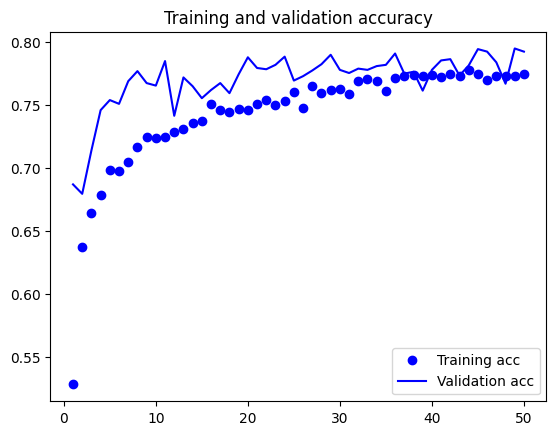

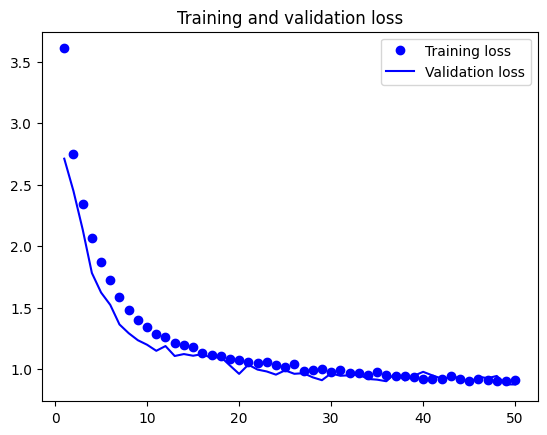

In [ ]:
# Plot accuracy and loss curves

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Load the model
from tensorflow import keras

#model = keras.models.load_model('food_inception_1.keras')
model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/DLIR/food_inception_1.keras')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 364s 7s/step - acc: 0.7670 - loss: 0.9384 
test acc: 0.7680000066757202


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


### Model: Food IN-2

- changed the number of neurons in the dense layers

In [ ]:
# Build the model

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import tensorflow as tf

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Freeze the convolutional base to prevent weight updates during initial training
conv_base.trainable = False

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,374,378 (119.68 MB)

 Trainable params: 9,571,594 (36.51 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history = model.fit(
      train_generator,
      epochs=30,
      validation_data=validation_generator,
      verbose=1)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 94s 275ms/step - acc: 0.4362 - loss: 5.1854 - val_acc: 0.6635 - val_loss: 1.8962
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 255ms/step - acc: 0.6411 - loss: 1.9841 - val_acc: 0.7190 - val_loss: 1.6052
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 77s 256ms/step - acc: 0.6662 - loss: 1.7266 - val_acc: 0.7170 - val_loss: 1.5085
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 77s 256ms/step - acc: 0.6739 - loss: 1.5718 - val_acc: 0.7455 - val_loss: 1.2693
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 253ms/step - acc: 0.6994 - loss: 1.4075 - val_acc: 0.7435 - val_loss: 1.2298
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 253ms/step - acc: 0.7047 - loss: 1.3212 - val_acc: 0.7545 - val_loss: 1.1656
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 254ms/step - acc: 0.7059 - loss: 1.2873 - val_acc: 0.7660 - val_loss: 1.0759
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 252ms/step - acc: 0.7121 - loss: 1.2166 - val_acc: 0.7810 - val_loss: 1.0092
Epoch 9/30
300/300 ━━━━━━━━━━━━━

In [ ]:
# save model

model.save('/content/drive/My Drive/Colab Notebooks/DLIR/food_inception_2.keras')

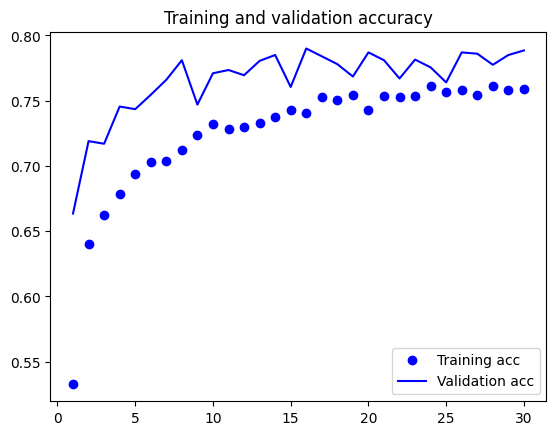

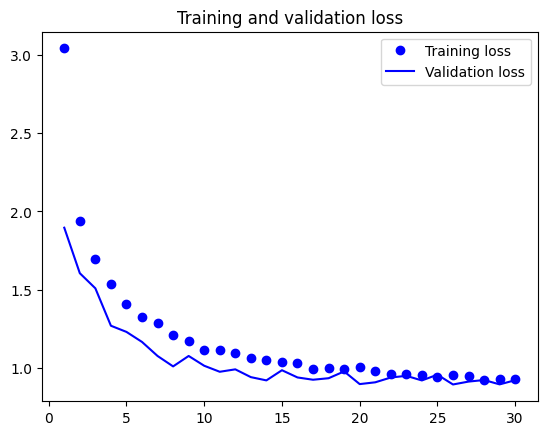

In [ ]:
# Plot accuracy and loss curves

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Load the model
from tensorflow import keras

#model = keras.models.load_model('food_inception_1.keras')
model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/DLIR/food_inception_2.keras')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - acc: 0.7671 - loss: 1.0045
test acc: 0.7699999809265137


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


## Fine tuning

Reloading the Model

In [ ]:
# get the model InceptionV3

from keras.applications.inception_v3 import InceptionV3
img_size = 150

conv_base = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_size, img_size, 3),
    pooling=None,
)

conv_base.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_470 (Conv2D) │ (None, 74, 74,    │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │         96 │ conv2d_470[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_470      │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_471 (Conv2D) │ (None, 72, 72,    │      9,216 │ activation_470[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_471[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_471      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_472 (Conv2D) │ (None, 72, 72,    │     18,432 │ activation_471[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_472[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_472      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 35, 35,    │          0 │ activation_472[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_473 (Conv2D) │ (None, 35, 35,    │      5,120 │ max_pooling2d_20… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_473[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_473      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_474 (Conv2D) │ (None, 33, 33,    │    138,240 │ activation_473[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_474[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_474      │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

### Model: Food IN-3

- began fine tuning of the pretrained component by unfreezing layers and evaluating the results.
- For this model, we unfroze the InceptionV3 convolutoinal layers from mix5.

In [ ]:
# initial setup

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import tensorflow as tf

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Freeze the convolutional base to prevent weight updates during initial training
conv_base.trainable = False

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,208,106 (157.20 MB)

 Trainable params: 19,405,322 (74.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Printed out the list of layers as a reference.

In [ ]:
# Access the conv_base layer directly from your Sequential model
conv_base = model.layers[0]

# Check the layers in the conv_base
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name)

0 input_layer
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_

Unfreezing layer Mix 5 (no. 164)

In [ ]:
# codes for unfreezing layers

# Decide which layers to unfreeze based on their names and your experiments
# For example, unfreeze from a certain layer index onwards
unfreeze_from_layer = 164 # mix5

for layer in conv_base.layers[:unfreeze_from_layer]:
   layer.trainable = False
for layer in conv_base.layers[unfreeze_from_layer:]:
   layer.trainable = True

# Recompile the model after changing the trainable status of layers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,208,106 (157.20 MB)

 Trainable params: 36,046,538 (137.51 MB)

 Non-trainable params: 5,161,568 (19.69 MB)

In [ ]:
history = model.fit(
      train_generator,
      epochs=50,
      validation_data=validation_generator,
      verbose=1)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 88s 196ms/step - acc: 0.4240 - loss: 3.6785 - val_acc: 0.7490 - val_loss: 2.5974
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - acc: 0.7066 - loss: 2.5624 - val_acc: 0.7915 - val_loss: 2.2981
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - acc: 0.7629 - loss: 2.1284 - val_acc: 0.8030 - val_loss: 1.8960
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 177ms/step - acc: 0.7962 - loss: 1.7658 - val_acc: 0.8360 - val_loss: 1.6016
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - acc: 0.8197 - loss: 1.4901 - val_acc: 0.8270 - val_loss: 1.4577
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 177ms/step - acc: 0.8367 - loss: 1.2696 - val_acc: 0.8415 - val_loss: 1.2869
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - acc: 0.8354 - loss: 1.1048 - val_acc: 0.8480 - val_loss: 1.1929
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - acc: 0.8644 - loss: 0.9266 - val_acc: 0.8420 - val_loss: 1.2066
Epoch 9/50
300/300 ━━━━━━━━━━━━━

In [ ]:
# save model

model.save('food_IN3_50.keras')

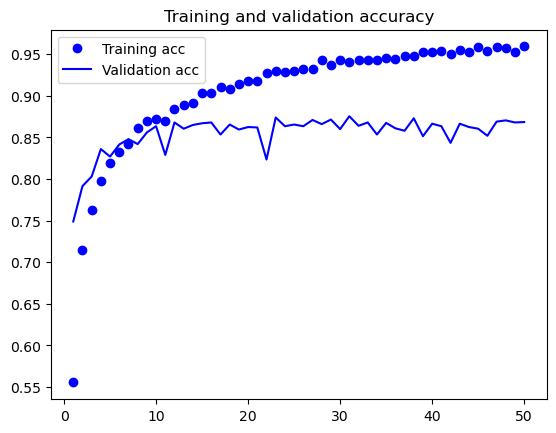

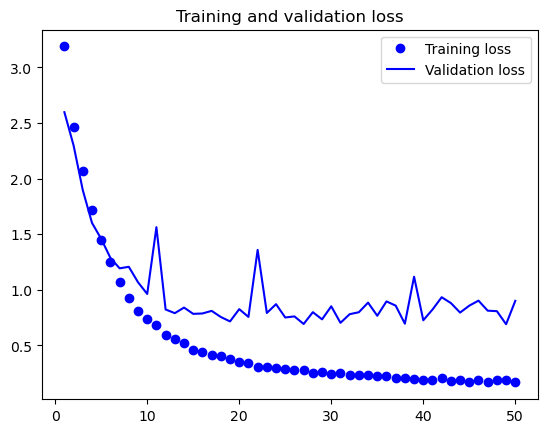

In [ ]:
# Plot accuracy and loss curves

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Load the model
from tensorflow import keras

#model = keras.models.load_model('food_inception_1.keras')
model = keras.models.load_model('food_IN3_50.keras')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - acc: 0.8570 - loss: 0.8511
test acc: 0.8519999980926514


### Model: Food IN-4

- unfreeze the pretrain layers at Mix 9 to check the effect of freezing near the top.

In [ ]:
# initial setup

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import tensorflow as tf

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Freeze the convolutional base to prevent weight updates during initial training
conv_base.trainable = False

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,208,106 (157.20 MB)

 Trainable params: 19,405,322 (74.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Unfreeze at mix9 (no. 279)

In [ ]:
# codes for unfreezing layers

# Decide which layers to unfreeze based on their names and your experiments
# For example, unfreeze from a certain layer index onwards
unfreeze_from_layer = 279 # mix9

for layer in conv_base.layers[:unfreeze_from_layer]:
   layer.trainable = False
for layer in conv_base.layers[unfreeze_from_layer:]:
   layer.trainable = True

# Recompile the model after changing the trainable status of layers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,208,106 (157.20 MB)

 Trainable params: 25,478,858 (97.19 MB)

 Non-trainable params: 15,729,248 (60.00 MB)

In [ ]:
history = model.fit(
      train_generator,
      epochs=30,
      validation_data=validation_generator,
      verbose=1)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 74s 194ms/step - acc: 0.5057 - loss: 3.4622 - val_acc: 0.7125 - val_loss: 2.7263
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 180ms/step - acc: 0.7004 - loss: 2.6503 - val_acc: 0.7740 - val_loss: 2.2927
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - acc: 0.7334 - loss: 2.3331 - val_acc: 0.8025 - val_loss: 2.0574
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - acc: 0.7512 - loss: 2.0998 - val_acc: 0.7890 - val_loss: 1.8734
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - acc: 0.7735 - loss: 1.8561 - val_acc: 0.7960 - val_loss: 1.7221
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 177ms/step - acc: 0.7771 - loss: 1.6910 - val_acc: 0.8095 - val_loss: 1.5757
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 52s 175ms/step - acc: 0.7867 - loss: 1.5392 - val_acc: 0.8035 - val_loss: 1.5133
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 176ms/step - acc: 0.7917 - loss: 1.4032 - val_acc: 0.8140 - val_loss: 1.3494
Epoch 9/30
300/300 ━━━━━━━━━━━━━

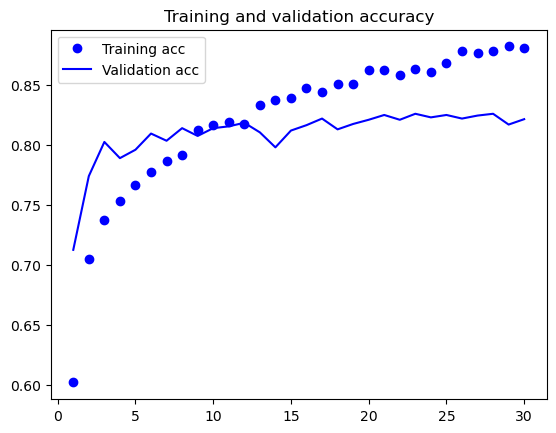

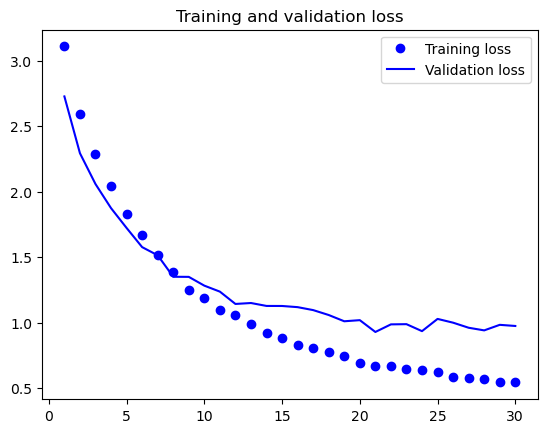

In [ ]:
# Plot accuracy and loss curves

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# save model

model.save('food_IN4.keras')

In [ ]:
# Load the model
from tensorflow import keras

model = keras.models.load_model('food_IN4.keras')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - acc: 0.8138 - loss: 0.9290
test acc: 0.8119999766349792


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


### Model: Food IN-5

- unfreeze the pretrain layers at Mix 4.

In [ ]:
# initial setup

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import tensorflow as tf

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Freeze the convolutional base to prevent weight updates during initial training
conv_base.trainable = False

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,208,106 (157.20 MB)

 Trainable params: 19,405,322 (74.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# codes for unfreezing layers

# Decide which layers to unfreeze based on their names and your experiments
# For example, unfreeze from a certain layer index onwards
unfreeze_from_layer = 132 # mix4

for layer in conv_base.layers[:unfreeze_from_layer]:
   layer.trainable = False
for layer in conv_base.layers[unfreeze_from_layer:]:
   layer.trainable = True

# Recompile the model after changing the trainable status of layers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,208,106 (157.20 MB)

 Trainable params: 37,735,818 (143.95 MB)

 Non-trainable params: 3,472,288 (13.25 MB)

In [ ]:
history = model.fit(
      train_generator,
      epochs=50,
      validation_data=validation_generator,
      verbose=1)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 195ms/step - acc: 0.4243 - loss: 3.6412 - val_acc: 0.7395 - val_loss: 2.7815
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - acc: 0.7224 - loss: 2.5352 - val_acc: 0.7825 - val_loss: 2.4018
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - acc: 0.7704 - loss: 2.1259 - val_acc: 0.8230 - val_loss: 1.9426
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - acc: 0.8013 - loss: 1.7662 - val_acc: 0.8300 - val_loss: 1.7231
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 177ms/step - acc: 0.8241 - loss: 1.5029 - val_acc: 0.8450 - val_loss: 1.4938
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - acc: 0.8397 - loss: 1.2641 - val_acc: 0.8580 - val_loss: 1.3056
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - acc: 0.8543 - loss: 1.0919 - val_acc: 0.8235 - val_loss: 1.7719
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - acc: 0.8738 - loss: 0.8972 - val_acc: 0.8310 - val_loss: 1.1436
Epoch 9/50
300/300 ━━━━━━━━━━━━━

In [ ]:
# save model

model.save('food_IN5.keras')

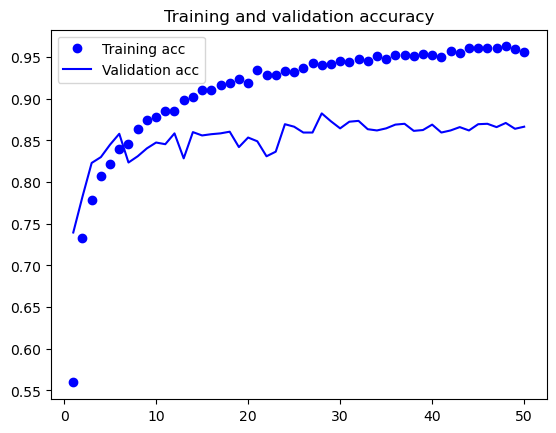

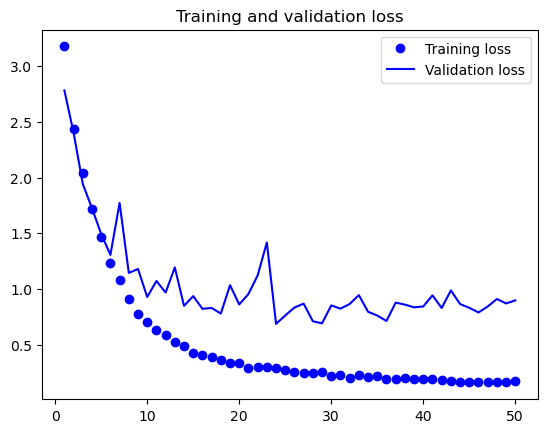

In [ ]:
# Plot accuracy and loss curves

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Load the model
from tensorflow import keras

model = keras.models.load_model('food_IN5.keras')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - acc: 0.8820 - loss: 0.7900
test acc: 0.878000020980835


### Model: Food IN-5

- unfreeze the pretrain layers at Mix 4.
- changed the optimizer from RMSprop to Adam.

In [ ]:
# get the model InceptionV3

from keras.applications.inception_v3 import InceptionV3
img_size = 150

conv_base = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_size, img_size, 3),
    pooling=None,
)

conv_base.summary()

I0000 00:00:1748863063.429703    1265 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5
W0000 00:00:1748863063.870572    1524 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /opt/conda/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /opt/conda/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /opt/conda/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting th

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
# Model setup

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import tensorflow as tf

model = models.Sequential()
model.add(conv_base) # InceptionV3 base
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Freeze the convolutional base to prevent weight updates during initial training
conv_base.trainable = False

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,208,106 (157.20 MB)

 Trainable params: 19,405,322 (74.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Unfreeze at mix 4 (no. 132) and changed the optimizer to Adam.

In [ ]:
# codes for unfreezing layers

unfreeze_from_layer = 132 # mix4

for layer in conv_base.layers[:unfreeze_from_layer]:
   layer.trainable = False
for layer in conv_base.layers[unfreeze_from_layer:]:
   layer.trainable = True

# Recompile the model after changing the trainable status of layers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,208,106 (157.20 MB)

 Trainable params: 37,735,818 (143.95 MB)

 Non-trainable params: 3,472,288 (13.25 MB)

In [ ]:
history = model.fit(
      train_generator,
      epochs=50,
      validation_data=validation_generator,
      verbose=1)

/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1748863233.857493    1518 service.cc:148] XLA service 0x7f5ae4017f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748863233.857519    1518 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-06-02 11:20:34.413230: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748863237.010961    1518 cuda_dnn.cc:529] Loaded cuDNN version 90800


  1/300 ━━━━━━━━━━━━━━━━━━━━ 3:25:28 41s/step - acc: 0.1600 - loss: 4.6894

I0000 00:00:1748863255.162980    1518 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 105s 213ms/step - acc: 0.4286 - loss: 3.6091 - val_acc: 0.7545 - val_loss: 2.5814
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 51s 171ms/step - acc: 0.7295 - loss: 2.6376 - val_acc: 0.7830 - val_loss: 2.3586
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - acc: 0.7658 - loss: 2.3641 - val_acc: 0.8295 - val_loss: 2.0717
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 51s 171ms/step - acc: 0.7945 - loss: 2.0885 - val_acc: 0.8460 - val_loss: 1.8485
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - acc: 0.8267 - loss: 1.8406 - val_acc: 0.8315 - val_loss: 1.7694
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - acc: 0.8282 - loss: 1.6720 - val_acc: 0.8460 - val_loss: 1.5745
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 51s 171ms/step - acc: 0.8471 - loss: 1.4530 - val_acc: 0.8410 - val_loss: 1.4299
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - acc: 0.8634 - loss: 1.2929 - val_acc: 0.8490 - val_loss: 1.3257
Epoch 9/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 51

In [ ]:
# save model

model.save('food_IN6.keras')

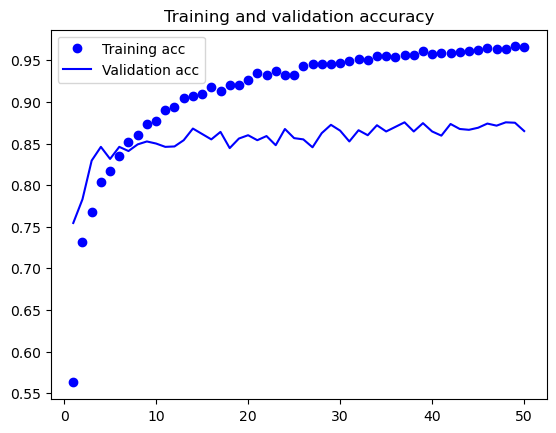

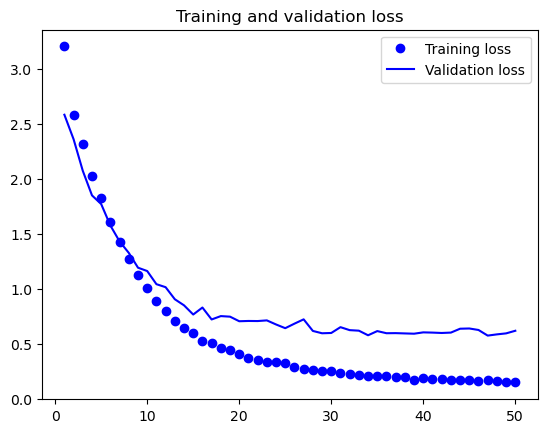

In [ ]:
# Plot accuracy and loss curves

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Load the model
from tensorflow import keras

model = keras.models.load_model('food_IN6.keras')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - acc: 0.8768 - loss: 0.5772
test acc: 0.8740000128746033


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


## Using Food IN-6 to make predictions (or rather, for classification)

Used some images downloaded from the internet to test the model.

In [ ]:
# Load the model
model = keras.models.load_model('food_IN6.keras')

In [ ]:
# Load the food list (in alphabetical order)
with open('food_list.txt', 'r') as f:
    x = f.readlines()
food_list =[]
for item in x:
    food_list.append(item.strip('\n'))
food_list = sorted(food_list) # food_list needs to be sorted alphabetically before feed into prediction() function
print(food_list)

['beet_salad', 'beignets', 'eggs_benedict', 'hamburger', 'hot_and_sour_soup', 'huevos_rancheros', 'lasagna', 'risotto', 'seaweed_salad', 'strawberry_shortcake']


In [ ]:
# Define some related functions for image process and model prediction
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def image_process(img):
    image = load_img(img, target_size =(img_size, img_size))
    image_array = img_to_array(image)/255
    return image_array

import pandas as pd
def prediction(model, img_array, items_l):
    prob = model.predict(img_array.reshape(1,img_size,img_size,3))
    pro_df = pd.DataFrame(prob, columns = items_l)
    result = items_l[np.argmax(prob)]
    return pro_df, result

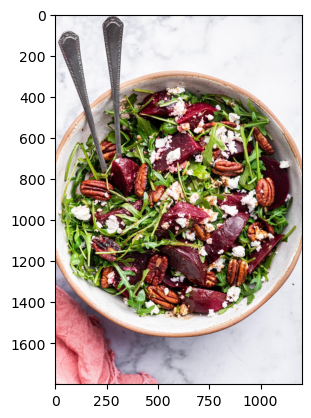

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
The prediction is:  beet_salad 

    beet_salad  beignets  eggs_benedict  hamburger  hot_and_sour_soup  \
0    0.951293  0.000003       0.000005   0.000013            0.02583   

   huevos_rancheros   lasagna   risotto  seaweed_salad  strawberry_shortcake  
0          0.000008  0.000002  0.000034       0.022802               0.00001  


In [ ]:
# Make prediction for the image you downloaded from internet
import numpy as np
import matplotlib.pyplot as plt
img = 'beet-salad-new-hero.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

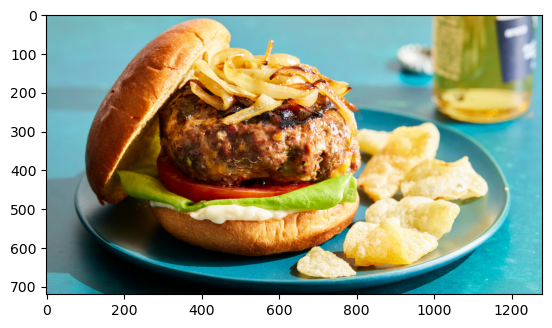

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
The prediction is:  hamburger 

      beet_salad  beignets  eggs_benedict  hamburger  hot_and_sour_soup  \
0  8.190054e-07  0.000007       0.000018   0.999964       1.280554e-07   

   huevos_rancheros       lasagna       risotto  seaweed_salad  \
0      3.150317e-07  5.229606e-07  1.670149e-07       0.000008   

   strawberry_shortcake  
0              0.000002  


In [ ]:
# Make prediction for the image you downloaded from internet
import numpy as np
import matplotlib.pyplot as plt
img = 'hamburger.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

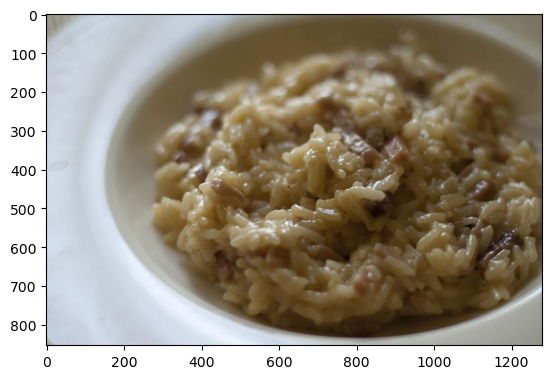

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
The prediction is:  risotto 

      beet_salad      beignets  eggs_benedict     hamburger  hot_and_sour_soup  \
0  2.382025e-10  3.067592e-09   3.660656e-10  1.686473e-09       2.588032e-10   

   huevos_rancheros       lasagna  risotto  seaweed_salad  \
0      4.616243e-11  5.100580e-08      1.0   4.861102e-10   

   strawberry_shortcake  
0          4.884877e-10  


In [ ]:
# Make prediction for the image you downloaded from internet
import numpy as np
import matplotlib.pyplot as plt
img = 'Risotto_with_speck_and_goat_cheese_wiki.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)